In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.impute import SimpleImputer
from scipy.stats import randint
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.cluster import KMeans
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/geoaidata/SampleSubmission.csv
/kaggle/input/geoaidata/Train.csv
/kaggle/input/geoaidata/Test.csv
/kaggle/input/lassoued-handles/geo_test.csv
/kaggle/input/lassoued-handles/geo_train.csv
/kaggle/input/geoai2/SampleSubmission.csv
/kaggle/input/geoai2/Train.csv
/kaggle/input/geoai2/Test.csv


In [4]:
train = pd.read_csv('/kaggle/input/geoaidata/Train.csv')
test = pd.read_csv('/kaggle/input/geoaidata/Test.csv')
sample = pd.read_csv('/kaggle/input/geoaidata/SampleSubmission.csv')
train.head()

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,ID_ENTGC7,1/1/19,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.0
1,ID_8JCCXC,1/1/19,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.0
2,ID_V3136Z,1/1/19,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.0
3,ID_KRVZDJ,1/1/19,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.0
4,ID_PR351A,1/1/19,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.0


In [5]:
test.head()

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure
0,ID_2MYNQS,1/1/19,PD03,45.289376,11.642394,3.277529,NaN,-0.313361,0.771456,0.000024,0.000075,NaN,14440.02819
1,ID_P4U5WU,1/1/19,TV03,45.836941,12.510362,0.000000,NaN,-0.229512,0.398208,0.000023,0.000120,NaN,14434.04790
2,ID_U4KWPK,1/1/19,X5561,45.582894,8.842165,0.000000,282.98,-0.470822,0.153694,0.000023,0.000171,0.000148,14427.42478
3,ID_QGSNTZ,1/1/19,X5953,45.131947,10.015742,1.928031,NaN,0.132952,0.756917,0.000024,0.000266,NaN,14443.09006
4,ID_GHSZ6K,1/1/19,X6701,45.186329,9.146666,0.000000,NaN,-0.198272,0.678858,0.000023,0.000149,NaN,14440.85840


In [6]:
print(train.shape)
print(test.shape)
print(sample.shape)

(86584, 14)
(6576, 13)
(6576, 2)


In [7]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86584 entries, 0 to 86583
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID_Zindi            86584 non-null  object        
 1   Date                86584 non-null  datetime64[ns]
 2   ID                  86584 non-null  object        
 3   LAT                 86584 non-null  float64       
 4   LON                 86584 non-null  float64       
 5   Precipitation       86584 non-null  float64       
 6   LST                 46798 non-null  float64       
 7   AAI                 73709 non-null  float64       
 8   CloudFraction       73709 non-null  float64       
 9   NO2_strat           73709 non-null  float64       
 10  NO2_total           73709 non-null  float64       
 11  NO2_trop            51111 non-null  float64       
 12  TropopausePressure  73709 non-null  float64       
 13  GT_NO2              82051 non-null  float64   

In [8]:
train['Date'].nunique()

1096

In [9]:
train_lassoued = pd.read_csv('/kaggle/input/lassoued-handles/geo_train.csv')
val_lassoued = pd.read_csv('/kaggle/input/lassoued-handles/geo_test.csv')
print(train_lassoued.shape)
print(val_lassoued.shape)

(12862, 15)
(6576, 14)


In [10]:
val_lassoued.columns

Index(['Date', 'LAT', 'LON', 'Precipitation', 'ID', 'NO2_total',
       'CloudFraction', 'NO2_strat', 'AAI', 'TropopausePressure', 'LST',
       'is_extreme_precipitation', 'High_CloudFraction',
       'NO2_total_to_strat_ratio'],
      dtype='object')

In [11]:
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)

In [12]:
numeric_columns1 = train.select_dtypes(include=[np.number]).columns
numeric_columns2 = test.select_dtypes(include=[np.number]).columns

daily_train = train.groupby(['Date'])[numeric_columns1].mean().reset_index()
daily_test = test.groupby(['Date'])[numeric_columns2].mean().reset_index()

daily_train

,Date,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,2019-01-01,45.421456,10.014272,0.617106,280.953784,-0.155558,0.483284,0.000024,0.000207,0.000175,14436.965572,35.105063
1,2019-01-02,45.421456,10.014272,8.310026,277.060000,-0.264583,0.990214,0.000028,0.000690,0.000146,17053.768295,47.965295
2,2019-01-03,45.421456,10.014272,0.137594,293.922025,-0.771366,0.234805,0.000038,0.000211,0.000242,19281.596463,38.013080
3,2019-01-04,45.421456,10.014272,0.000000,300.500506,-0.927630,0.079885,0.000050,0.000167,0.000117,19287.903031,34.908966
4,2019-01-05,45.421456,10.014272,0.000000,304.646329,-1.095072,0.016933,0.000062,0.000137,0.000075,19283.271515,13.958228
...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2021-12-27,45.421456,10.014272,3.219481,278.209873,-1.146694,0.240020,0.000029,0.000175,0.000105,19307.223758,36.854008
1092,2021-12-28,45.421456,10.014272,2.321739,273.435190,-0.579049,0.362770,0.000027,0.000124,0.000122,16665.990926,37.197468
1093,2021-12-29,45.421456,10.014272,0.349799,272.760000,0.740545,0.162093,0.000031,0.000134,0.000100,15474.864521,33.401371
1094,2021-12-30,45.421456,10.014272,0.000000,276.912405,0.249971,0.121174,0.000034,0.000266,0.000253,13059.315989,35.866456


<Axes: xlabel='Date'>

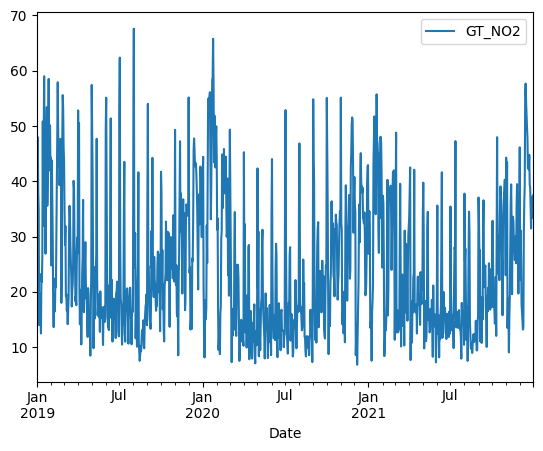

In [13]:
daily_train.set_index('Date')[['GT_NO2']].plot()

In [14]:
# Add additional temporal features
daily_train['DayOfWeek'] = daily_train['Date'].dt.dayofweek
daily_train['Month'] = daily_train['Date'].dt.month
daily_train['DayOfYear'] = daily_train['Date'].dt.dayofyear

daily_test['DayOfWeek'] = daily_test['Date'].dt.dayofweek
daily_test['Month'] = daily_test['Date'].dt.month
daily_test['DayOfYear'] = daily_test['Date'].dt.dayofyear


In [15]:
# Fill missing values
daily_train.fillna(method='ffill', inplace=True)
daily_test.fillna(method='ffill', inplace=True)

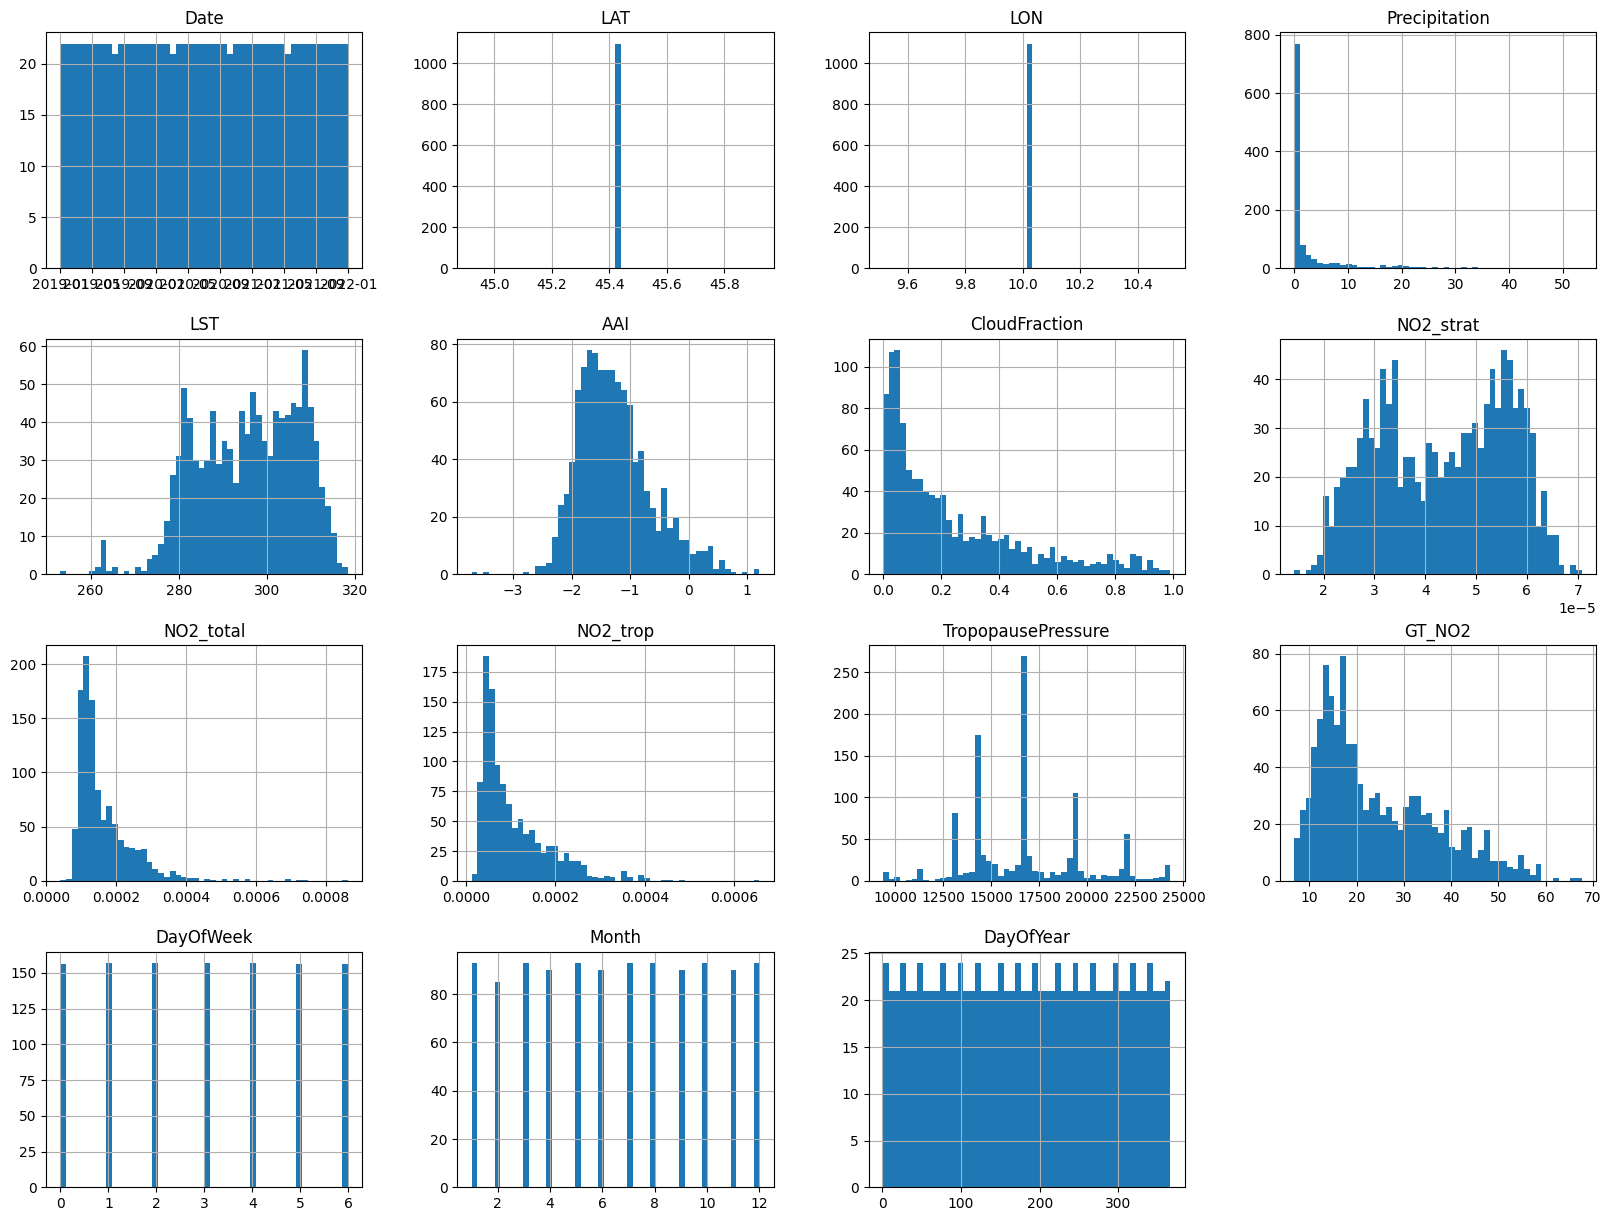

In [16]:
daily_train.hist(bins=50, figsize=(20, 15))
plt.show()

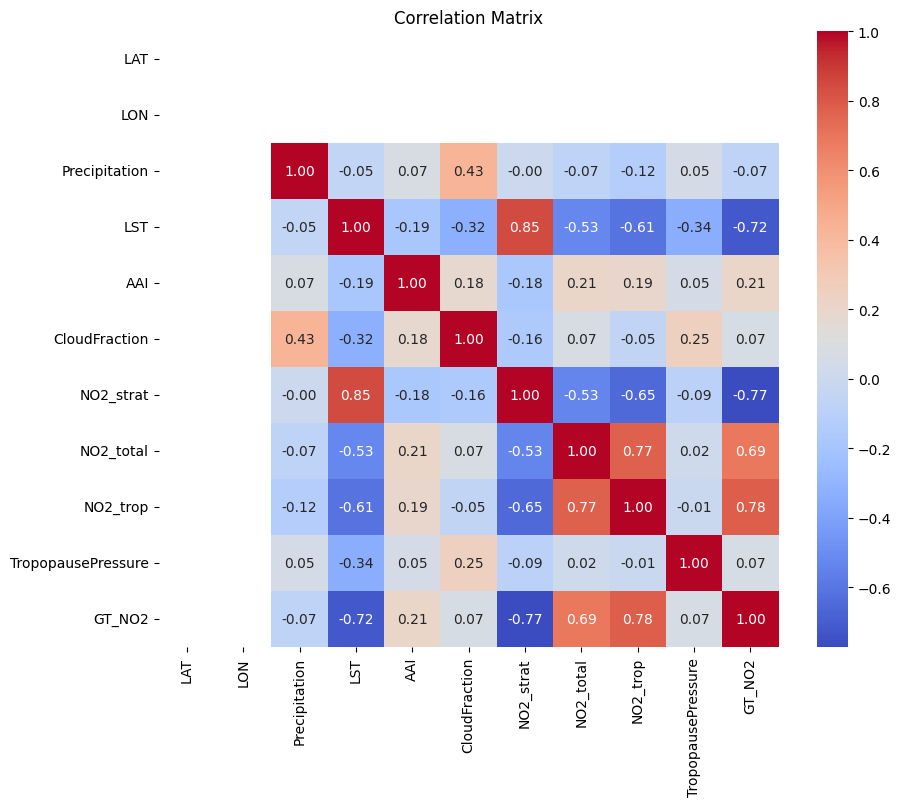

In [17]:
numeric_columns = daily_train.select_dtypes(include=np.number).columns
corr_matrix = daily_train[numeric_columns1].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

plt.show()

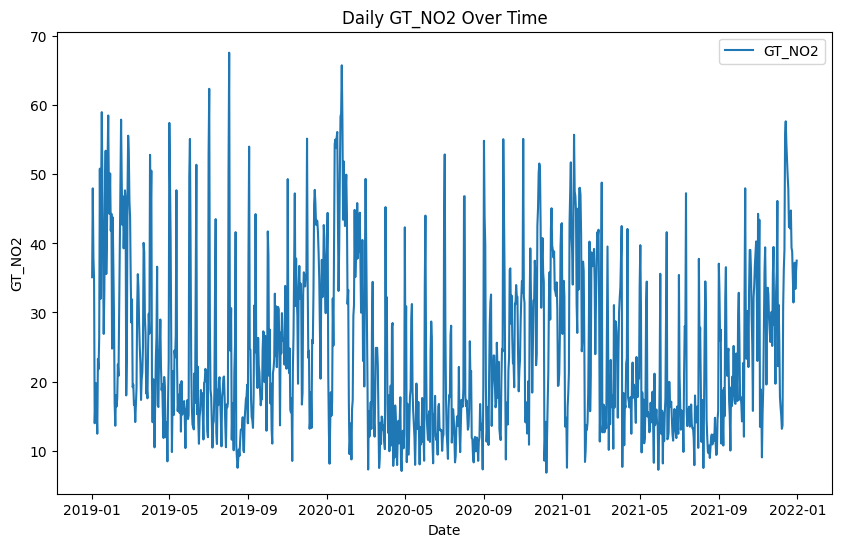

In [18]:
# Time series analysis
plt.figure(figsize=(10, 6))
plt.plot(daily_train['Date'], daily_train['GT_NO2'], label='GT_NO2')
plt.xlabel('Date')
plt.ylabel('GT_NO2')
plt.title('Daily GT_NO2 Over Time')
plt.legend()
plt.show()

In [19]:
# Interaction features
train['LST_NO2'] = train['LST'] * train['NO2_total']
test['LST_NO2'] = test['LST'] * test['NO2_total']
# Temperature differences
train['Temp_Diff'] = train['LST'] - train['TropopausePressure']
test['Temp_Diff'] = test['LST'] - test['TropopausePressure']
# Clustering example
kmeans = KMeans(n_clusters=5, random_state=42)
train['Cluster'] = kmeans.fit_predict(train[['LAT', 'LON']])
test['Cluster'] = kmeans.predict(test[['LAT', 'LON']])

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose NO2_total in the training set
decomposition_train = seasonal_decompose(train['NO2_total'], period=365, model='additive')
train['NO2_seasonal'] = decomposition_train.seasonal
train['NO2_trend'] = decomposition_train.trend
train['NO2_residual'] = decomposition_train.resid

# Fill missing values in the decomposed components in the training set
train['NO2_trend'].fillna(method='bfill', inplace=True)
train['NO2_trend'].fillna(method='ffill', inplace=True)
train['NO2_seasonal'].fillna(0, inplace=True)  # Seasonal component should average around 0 if missing

# Now perform decomposition for the test set
decomposition_test = seasonal_decompose(test['NO2_total'], period=365, model='additive')
test['NO2_seasonal'] = decomposition_test.seasonal
test['NO2_trend'] = decomposition_test.trend
test['NO2_residual'] = decomposition_test.resid

# Fill missing values in the decomposed components in the test set
test['NO2_trend'].fillna(method='bfill', inplace=True)
test['NO2_trend'].fillna(method='ffill', inplace=True)
test['NO2_seasonal'].fillna(0, inplace=True)

In [21]:
# # Rolling features
# train['NO2_total_roll_mean'] = train['NO2_total'].rolling(window=3).mean()
# test['NO2_total_roll_mean'] = test['NO2_total'].rolling(window=3).mean()

# train['LST_roll_mean'] = train['LST'].rolling(window=3).mean()
# test['LST_roll_mean'] = test['LST'].rolling(window=3).mean()

In [22]:
train.head(3)

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2,LST_NO2,Temp_Diff,Cluster,NO2_seasonal,NO2_trend,NO2_residual
0,ID_ENTGC7,2019-01-01,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.0,NaN,NaN,1,-0.000003,0.000183,NaN
1,ID_8JCCXC,2019-01-01,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.0,NaN,NaN,1,0.000003,0.000183,NaN
2,ID_V3136Z,2019-01-01,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.0,NaN,NaN,1,0.000004,0.000183,NaN


In [23]:
# Feature engineering - adding date features
for df in [train, test]:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['Quarter'] = df['Date'].dt.quarter

for df in [train, test]:
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 365)
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 365)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

train['Cloud_NO2'] = train['CloudFraction'] * train['NO2_total']
test['Cloud_NO2'] = test['CloudFraction'] * test['NO2_total']

train['NO2_total_cluster_mean'] = train.groupby(['Cluster'])['NO2_total'].transform('mean')
train['NO2_total_month_mean'] = train.groupby(['Month'])['NO2_total'].transform('mean')
train['NO2_total_weekday_mean'] = train.groupby(['DayOfWeek'])['NO2_total'].transform('mean')

test['NO2_total_cluster_mean'] = test.groupby(['Cluster'])['NO2_total'].transform('mean')
test['NO2_total_month_mean'] = test.groupby(['Month'])['NO2_total'].transform('mean')
test['NO2_total_weekday_mean'] = test.groupby(['DayOfWeek'])['NO2_total'].transform('mean')

train['Precip_NO2'] = train['Precipitation'] * train['NO2_total']
test['Precip_NO2'] = test['Precipitation'] * test['NO2_total']


train_filled = pd.DataFrame(train, columns=train.drop(['ID', 'ID_Zindi','GT_NO2', 'Date'], axis=1).columns)
test_filled = pd.DataFrame(test, columns=test.drop(['ID', 'ID_Zindi', 'Date'], axis=1).columns)
# Add engineered date features to imputed data
train_filled['Year'] = train['Year']
train_filled['Month'] = train['Month']
train_filled['Day'] = train['Day']
train_filled['DayOfWeek'] = train['DayOfWeek']
train_filled['WeekOfYear'] = train['WeekOfYear']
train_filled['Quarter'] = train['Quarter']

test_filled['Year'] = test['Year']
test_filled['Month'] = test['Month']
test_filled['Day'] = test['Day']
test_filled['DayOfWeek'] = test['DayOfWeek']
test_filled['WeekOfYear'] = test['WeekOfYear']
test_filled['Quarter'] = test['Quarter']

# Add polynomial features
'''poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
train_poly = poly.fit_transform(train_filled)
test_poly = poly.transform(test_filled)'''
train_filled = train_filled.drop(columns=['GT_NO2'], errors='ignore')
test_filled = test_filled.drop(columns=['GT_NO2'], errors='ignore')
test_filled = test_filled[train_filled.columns]
# Scale the features
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(train_filled)
scaled_test_features = scaler.transform(test_filled)

imputer = SimpleImputer(strategy='mean') 
scaled_train_features = imputer.fit_transform(scaled_train_features)
scaled_test_features = imputer.transform(scaled_test_features)

scaled_train1 = pd.DataFrame(scaled_train_features, columns=train_filled.columns)
scaled_test1 = pd.DataFrame(scaled_test_features, columns=train_filled.columns)

In [24]:
import folium
import pandas as pd

# Drop duplicates to get unique locations only
train_unique = train.drop_duplicates(subset=['LAT', 'LON'])
test_unique = test.drop_duplicates(subset=['LAT', 'LON'])

# Initialize the map centered around an average location
map_center = [train['LAT'].mean(), train['LON'].mean()]
m = folium.Map(location=map_center, zoom_start=8)

# Add train data points in blue color with LAT and LON in popup
for _, row in train_unique.iterrows():
    folium.Marker(
        location=[row['LAT'], row['LON']],
        popup=f"Train Point<br>LAT: {row['LAT']}<br>LON: {row['LON']}",
        icon=folium.Icon(color='blue')
    ).add_to(m)

# Add test data points in red color with LAT and LON in popup
for _, row in test_unique.iterrows():
    folium.Marker(
        location=[row['LAT'], row['LON']],
        popup=f"Test Point<br>LAT: {row['LAT']}<br>LON: {row['LON']}",
        icon=folium.Icon(color='red')
    ).add_to(m)
m

In [25]:
#scaled_train.drop(['LON' , "LAT"] , axis = 1 , inplace  = True)
#scaled_test.drop(['LON' , "LAT"] , axis= 1  , inplace =True)

In [26]:
# def lat_lon_to_polar(data, lat_col='LAT', lon_col='LON'):
#     # Convert to radians
#     data['lat_rad'] = np.radians(data[lat_col])
#     data['lon_rad'] = np.radians(data[lon_col])
   
#     # Assume Earth's radius in kilometers
#     R = 6371  # Earth's radius in km
#     data['x'] = R * np.cos(data['lat_rad']) * np.cos(data['lon_rad'])
#     data['y'] = R * np.cos(data['lat_rad']) * np.sin(data['lon_rad'])
#     data['z'] = R * np.sin(data['lat_rad'])
   
#     # Drop intermediate columns
#     data.drop(['lat_rad', 'lon_rad'], axis=1, inplace=True)
#     return data

# def rotate_lat_lon(data, angle=45, x_col='x', y_col='y'):
#     angle_rad = np.radians(angle)
#     cos_angle = np.cos(angle_rad)
#     sin_angle = np.sin(angle_rad)
   
#     # Rotation matrix application
#     data['x_rotated'] = cos_angle * data[x_col] - sin_angle * data[y_col]
#     data['y_rotated'] = sin_angle * data[x_col] + cos_angle * data[y_col]
   
#     # Dropping original x, y columns
#     data.drop([x_col, y_col], axis=1, inplace=True)
#     return data
# scaled_train1 = lat_lon_to_polar(scaled_train1)
# scaled_test1 = lat_lon_to_polar(scaled_test1)

# scaled_train1 = rotate_lat_lon(scaled_train1)
# scaled_test1 = rotate_lat_lon(scaled_test1)

In [27]:
# import xgboost as xgb

# X_train, X_val, y_train, y_val = train_test_split(
#     scaled_train, train['GT_NO2'], test_size=0.2, random_state=42
# )
# best_params = {
#     'n_estimators': 400,
#     'max_depth': 7,
#     'learning_rate': 0.08708086042124147,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'random_state': 42
# }
# xgb_model = xgb.XGBRegressor(**best_params)
# xgb_model.fit(X_train, y_train)

# y_pred_xgb_val = xgb_model.predict(X_val)
# rmse_xgb_val = sqrt(mean_squared_error(y_val, y_pred_xgb_val))
# print(f'XGBoost RMSE on validation set: {rmse_xgb_val}')

# importances = xgb_model.feature_importances_
# feature_names = np.array(scaled_train.columns)
# fi = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# fi = fi.sort_values(by='Importance', ascending=False)

# plt.figure(figsize=(10, 6))
# plt.barh(fi['Feature'], fi['Importance'], color='skyblue')
# plt.title('Feature Importances from XGBoost')
# plt.xlabel('Importance')
# plt.ylabel('Features')
# plt.show()

# y_pred_xgb = xgb_model.predict(scaled_test)

In [31]:
import optuna
from xgboost import XGBRegressor

X_train, X_val, y_train, y_val = train_test_split(
    scaled_train1, train['GT_NO2'], test_size=0.2, random_state=42
)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 30, step=5),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': 42
    }
    
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)

    y_pred_val = model.predict(X_val)
    rmse = sqrt(mean_squared_error(y_val, y_pred_val))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)


[I 2024-11-13 17:40:49,393] A new study created in memory with name: no-name-28e18f08-c2fb-4bcf-bb1a-6b68d4fdd3c7
[I 2024-11-13 17:42:20,832] Trial 0 finished with value: 6.969911984861723 and parameters: {'n_estimators': 300, 'max_depth': 18, 'learning_rate': 0.027482137738613258, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8, 'gamma': 0.9521978855413782}. Best is trial 0 with value: 6.969911984861723.
[I 2024-11-13 17:47:46,308] Trial 1 finished with value: 7.34505003779144 and parameters: {'n_estimators': 300, 'max_depth': 28, 'learning_rate': 0.014594710693711495, 'subsample': 0.6, 'colsample_bytree': 0.8, 'min_child_weight': 2, 'gamma': 0.09579878423175314}. Best is trial 0 with value: 6.969911984861723.
[I 2024-11-13 17:48:44,599] Trial 2 finished with value: 7.356496234706701 and parameters: {'n_estimators': 400, 'max_depth': 18, 'learning_rate': 0.0864459565234046, 'subsample': 0.6, 'colsample_bytree': 0.7, 'min_child_weight': 2, 'gamma': 2.596859618620467}. 

In [36]:
lgb_params = {'n_estimators': 500, 'max_depth': 24,
              'learning_rate': 0.01145044133988524,
              'num_leaves': 90,
              'min_child_samples': 35,
              'subsample': 0.9,
              'colsample_bytree': 0.5}
xgb_params = {'n_estimators': 400,
              'max_depth': 8, 
              'learning_rate': 0.05583133593935971,
              'subsample': 0.6, 
              'colsample_bytree': 0.8,
              'min_child_weight': 9,
              'gamma': 0.6676786740228895}

In [42]:
from sklearn.model_selection import KFold

target = "GT_NO2"
X = scaled_train1.select_dtypes(include=['number'])
y = train[target]
TEST = scaled_test1

folds = KFold(n_splits=5, shuffle=True, random_state=42)
preds_ensemble = []

for train_index, test_index in folds.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lgb_regressor = lgb.LGBMRegressor(**lgb_params, early_stopping=100)
    lgb_regressor.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    y_pred_lgb = lgb_regressor.predict(X_test)

    xgb_regressor = XGBRegressor(**xgb_params, early_stopping_rounds=100)
    xgb_regressor.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    y_pred_xgb = xgb_regressor.predict(X_test)

    y_pred_ensemble = 0.8 * y_pred_lgb + 0.2 * y_pred_xgb
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
    print(f'Fold RMSE: {rmse:.4f}')

    preds_ensemble.append(0.8 * lgb_regressor.predict(TEST) + 0.2 * xgb_regressor.predict(TEST))

final_preds = np.mean(preds_ensemble, axis=0)
print(f'Final Test Set Predictions: {final_preds}')

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4469
[LightGBM] [Info] Number of data points in the train set: 69267, number of used features: 36
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Start training from score 24.486950
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 59.6159
[0]	validation_0-rmse:16.41553
[1]	validation_0-rmse:15.87282
[2]	validation_0-rmse:15.36808
[3]	validation_0-rmse:14.91374
[4]	validation_0-rmse:14.49422
[5]	validation_0-rmse:14.09285
[6]	validation_0-rmse:13.71728
[7]	validation_0-rmse:13.36494
[8]	validat

In [43]:
sample['GT_NO2'] = np.mean(preds_lgb2 , axis  = 0)
sample.to_csv('submission_lgbm.csv', index=False)

In [44]:
test['GT_NO2'] = sample['GT_NO2'].values

In [45]:
test.loc[(test['LON'] == 12.51036156) & (test['LAT'] == 45.83694093), 'GT_NO2'] *= 0.65
test.loc[(test['LON'] == 11.64239391) & (test['LAT'] == 45.28937609), 'GT_NO2'] *= 0.7 # may be better
test.loc[(test['LON'] == 8.842165457) & (test['LAT'] == 45.58289429), 'GT_NO2'] *= 1.1 # 
test.loc[(test['LON'] == 9.146666041) & (test['LAT'] == 45.18632908), 'GT_NO2'] *= 1.2 # 
test.loc[(test['LON'] == 10.7814077) & (test['LAT'] == 45.15174338), 'GT_NO2'] *= 1.15 # 
test.loc[(test['LON'] == 10.01574151) & (test['LAT'] == 45.13194691), 'GT_NO2'] *= 1.1 # 


In [46]:
sample['GT_NO2'] = test['GT_NO2'].values

In [47]:
sample.to_csv('first.csv' , index = False)

In [ ]:
45.13194691
10.01574151